<h1><center>
    Grid World - Reinforcement Learning <br/>
  
    
    Project 3
</center></h1>

Team: **Alvier**

 - **Siddhant Sahu** (20-744-579)
 - **Deborah Jakobi** (16-054-165)
 - **Mengqi Wang** (19-754-027)
 - **Tijana Kostovic** (16-720-443)
 - ~~Francesco Tinner (17-709-510)~~  &rarr; does not contribute to this assignment

In [ ]:
# The following code was adapted from a demo given by Andreas Krause in the course Probabilistic AI at ETH in 2021.

import numpy as np

import torch
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import copy 

from rllib.environment.mdps import EasyGridWorld
from rllib.value_function import TabularValueFunction
from rllib.policy import TabularPolicy

environment = EasyGridWorld()
gamma = 0.9

# Plotters
def policy2str(policy):
    left = u'\u2190'
    right = u'\u2192'
    up = u'\u2191'
    down = u'\u2193'
    policy_str = ""
    if 0 == policy:
        policy_str += down 
    if 1 == policy:
        policy_str += up 
    if 2 == policy:
        policy_str += right
    if 3 == policy:
        policy_str += left
    return policy_str

def plot_value_function(value_function, ax):
    ax.imshow(value_function, vmin=-1, vmax=30)
    rows, cols = value_function.shape
    for row in range(rows):
        for col in range(cols):
            ax.text(row, col, f"{value_function[col, row]:.1f}", ha="center", va="center", color="w", fontsize=24)

def plot_policy(policy, ax):
    rows, cols = policy.shape
    ax.imshow(np.zeros((rows, cols)))
    for row in range(environment.height):
        for col in range(environment.width):
            ax.text(col, row, policy2str(policy[row, col]), ha="center", va="center", color="r", fontsize=24)

def plot_value_and_policy(value_function, policy):
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20, 8))

    plot_value_function(value_function, axes[0])
    plot_policy(policy, axes[1])

## Task 1 - Policy Evaluation

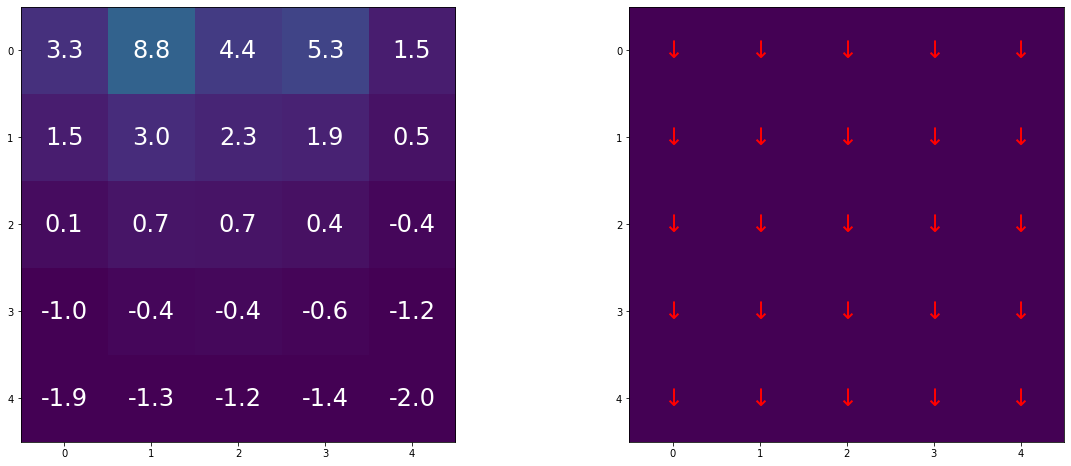

In [ ]:
def init_policy_and_value_function():
    ### ---Task 1.1--- ###
    ### YOUR CODE HERE ###
    policy = TabularPolicy(num_states=environment.num_states, 
                           num_actions=environment.num_actions)
    value_function = TabularValueFunction(num_states=environment.num_states)
    
    ### YOUR CODE END  ###
    
    return policy, value_function

def linear_system_policy_evaluation(environment, policy, gamma, value_function):

    P, r = build_mrp_matrices(environment=environment, policy=policy)
    

    ### ---Task 1.2--- ###
    ### YOUR CODE HERE ###

    P2 = torch.eye(environment.num_states) - gamma * P
    vals = P2.inverse() @ r
    
    ### YOUR CODE END  ###    
    
    for state in range(environment.num_states):
        value_function.set_value(state, vals[state].item())

    return value_function

def build_mrp_matrices(environment, policy):
    mrp_kernel = np.zeros((environment.num_states, environment.num_states))
    mrp_reward = np.zeros((environment.num_states))

    for state in range(environment.num_states):
        state = torch.tensor(state).long()
        policy_ = Categorical(logits=policy(state))

        for a, p_action in enumerate(policy_.probs):
            for transition in environment.transitions[(state.item(), a)]:
                with torch.no_grad():
                    p_ns = transition["probability"]
                    mrp_reward[state] += p_action * p_ns * transition["reward"]
                    mrp_kernel[state, transition["next_state"]
                               ] += p_action * p_ns

    return mrp_kernel, mrp_reward

### ---Task 1.3--- ###
policy, value_function = init_policy_and_value_function()
value_function = linear_system_policy_evaluation(environment, policy, gamma, value_function)

plot_value_and_policy(value_function.table.reshape(5, 5).detach().numpy(),
                      policy.table.argmax(0).reshape(5, 5).detach().numpy())

## Theory Question 1 - Linear convergence of Policy Iteration

### Question a)
Starting from the Bellman operator:

$$ $$
$BV^{\pi_t}(x) = \max_{a} [r(x,a) + \gamma\mathbb{E}_{x'|x,a}[V^{\pi_t}(x')]]$ 


$\hspace{21 mm}\geq r(x,{\pi_t}(x)) + \gamma\mathbb{E}_{x'|x,\pi_{t}(x)}[V^{\pi_t}(x')]\hspace{10 mm}$| by def. of max

$\hspace{21 mm}= V^{\pi_t}(x).$

### Question b)
Here we need to show that by using a better policy in a new state the value obtained should be higher or equal to the old value computed by the Bellman equation.

The hint suggests to use induction over t with the fixed point iteration algorithm. 

Let $\hspace{3 mm} S_1(x) = BV^{\pi_t}(x) \hspace{3 mm}$ and $\hspace{3 mm} S_0(x) = V^{\pi_t}(x)$

The fixed point iteration algorithm initializes $S_0$ as defined above then updates $S_i$ within a for loop ranging from $i=0$ to $i=T$.


Since $BV^{\pi_t}(x) \geq V^{\pi_t}(x)$ we need to show that $S_i(x) \geq S_{i-1}(x)$ holds, which means that $S_i$ is monotonically increasing

$$ $$
$$
S_i(x) = r(x,{\pi_{t+1}}(x)) + \gamma\mathbb{E}_{s'|s,{\pi_{t+1}}(x)}[S_{i-1}]$$

$$\hspace{13 mm} \geq r(x,{\pi_{t+1}}(x)) + \gamma\mathbb{E}_{s'|s,{\pi_{t+1}}(x)}[S_{i-2}]$$

$$\hspace{-41 mm} = S_{i-1}(x)$$
$$ $$

With this we have shown that $S_i(x) \geq S_{i-1}(x)$ is monotonically increasing and therefore the value function with the new policy $\pi_{t+1}$ applicable is bigger or equal to the function computed by the Bellman equation with the old policy $\pi_t$:
$$ $$ 
$$V^{\pi_{t+1}}(x) \geq BV^{\pi_t}(x)$$

### Question c)
The optimal value function should be bigger or equal to any other value function for any applicable policy: $V^* \geq V^\pi \forall \pi$.

In part b) we have proven that $V^{\pi_{t+1}}(x) \geq BV^{\pi_t}(x)$ holds. Subtracting the optimal value function $V^*$ on both sides and taking the $L_\infty$ norm then the following must hold by definition of the $L_\infty$ norm:
$$ $$
$$ || V^{\pi_{t+1}}(x) - V^* ||_\infty \leq ||BV^{\pi_t}(x) - V^* ||_\infty$$ 
$$ $$
The second hint says that $B$ is a contraction, this means that $B$ must be monotone and there exists a discount factor $\gamma \in (0,1)$. Moreover, the last hint suggests to use $BV^* = V^*$. 

By induction:
$$ $$

$ || V^{\pi_{t+1}}(x) - V^* ||_\infty \leq ||BV^{\pi_t}(x) - BV^* ||_\infty  \hspace{10mm} |$  using BV* = V*

$ \hspace{43mm}  \leq ||B(V^{\pi_t}(x) - V^*) ||_\infty$

$ \hspace{43mm}  \leq \gamma||V^{\pi_t}(x) - V^* ||_\infty$ $\hspace{14mm}|$   using contractive property of $B$

$ \hspace{43mm}  \leq \gamma^1||V^{\pi_{t-1}}(x) - V^* ||_\infty$ 

$ \hspace{43mm}  ... $ 

$ \hspace{43mm}  \leq \gamma^t||V^{\pi_{1}}(x) - V^* ||_\infty $ 

$$ $$

We can see that it decays exponentially as $t$ goes to 1 where the very first policy was used and then got monotonically improved policies and value functions.

## Task 2 - Policy Iteration

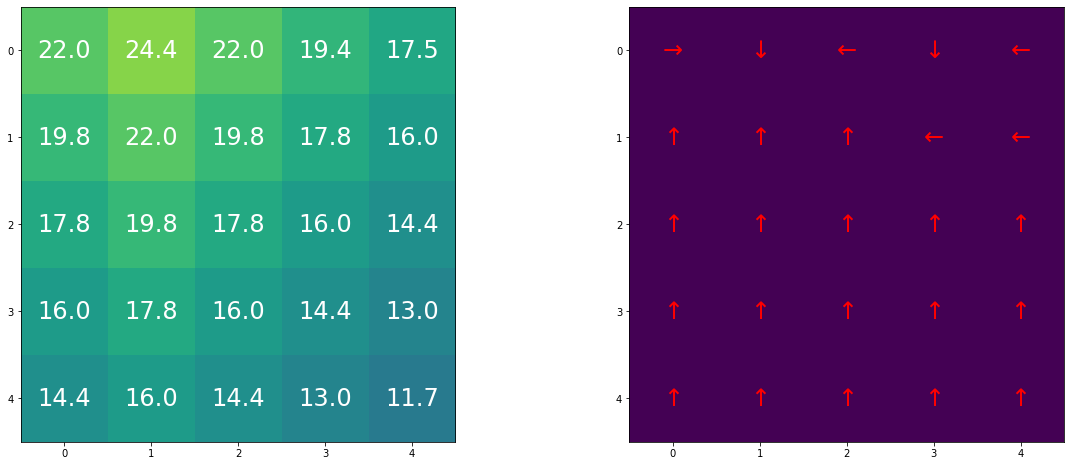

In [ ]:
# Policy Iteration
def policy_iteration(environment, gamma):
    """Implement Policy Iteration algorithm.

    Parameters
    ----------
    gamma: float.
        discount factor.

    References
    ----------
    Sutton, R. S., & Barto, A. G. (2018). Reinforcement learning: An introduction.
    MIT press.
    Chapter 4.3

    """
    
    policy, value_function = init_policy_and_value_function()
    


    while True:
        # Evaluate the policy.
        value_function = linear_system_policy_evaluation(environment, policy, gamma, value_function)

        policy_stable = True
        # iterate through all states
        for state in range(environment.num_states):
            # initialize values
            value_ = torch.zeros(environment.num_actions)
            
            # iterate through possible actions
            for action in range(environment.num_actions):
                value_estimate = 0
                
                # iterate through transitions
                for transition in environment.transitions[(state, action)]:
                    next_state = torch.tensor(transition["next_state"]).long()
                    reward = torch.tensor(transition["reward"]).double()
                    transition_probability = transition["probability"]

                    
                    ### ---Task 2.1--- ###
                    # Update the value estimate for each transition, i.e. each (state, action) pair.
                    ### YOUR CODE HERE ###
                    value_estimate += transition_probability*(reward + gamma*value_function(next_state))
        
                    ### YOUR CODE END

                value_[action] = value_estimate

            state = torch.tensor(state).long()
            old_policy = policy(state)
            old_action = torch.argmax(old_policy)

            action = torch.argmax(value_)
            policy.set_value(state, action)
            
            ### ---Task 2.2--- ###
            # Check if the policy is stable, i.e. if any of the actions of the policy have changed since the last iteration
            ### YOUR CODE HERE ###
            policy_stable &= action == old_action

            ### YOUR CODE END  ###

        if policy_stable:
            break

    return value_function, policy

### ---Task 2.3--- ###
# Run the policy iteration algorithm, and save the plots as part of your submission in a permanent format (png/pdf/...).
value_function, policy = policy_iteration(environment, gamma)
plot_value_and_policy(value_function.table.reshape(5, 5).detach().numpy(),
                      policy.table.argmax(0).reshape(5, 5).detach().numpy())

## Theory Question 2

> In your own words, compare and contrast policy iteration and value iteration in a few sentences. I.e. what are the advantages and disadvantages of either? 

1. Value iteration is simpler to implement and less complex. For policy iteration it is necessary to evaluate the policy first which is an additional function that needs to be executed. In value iteration we do not have this explicit policy evaluation step first. Policy interation is faster as it was basically done after very few iterations (around 5 in our case, we checked it by printing some output which is not in the notebook anymore). 


2. The main difference to the policy iteration is that we take the maximum over all possible actions in the value iteration algorithm. This means instead that for every iteration we evaluate and improve the policy, we udpate the state value function directly, but for this all possible rewards for a step ahead must be computed and the action maximizing the value function is then taken.

3. The value iteration covers the two phases of the policy iteration by taking the maximum action over the value function for all possible actions. Since it needs to run through all possible actions to get the maximum action value, it is computationally more expensive and takes as already said more iterations to converge.

4. In Policy Iteration we use the Bellman "**Expectation**" equation [1], but in Value Iteration we use the Bellman "**Optimality**" equation [2], with the equations.
\begin{equation}
v_\pi(s) = \sum_{a \in A}^{}\pi(a|s)(R_s^a + γ ∑_{s' \in S} P_{ss'}^a v_\pi(s')) \tag{1}
\end{equation}

\begin{equation}
v_*(s) = \max_a(R_s^a + γ ∑_{s' \in S} P_{ss'}^a v_*(s')) \tag{2}
\end{equation}

5. Value Iteration works exclusively in the value space, and hence, the intermediate value function might not correspond to any real actual policy. But asymptotically it converges to the optimal policy. But, this is not the case in Policy Iteration, in each iteration, every intermediate value function corresponds to a valid policy in that iteration.


> What are the types of problem to which they can be applied? 

Both algorithms are dynamic programming algorithms which require that the environments dynamics are completely known. For this we assume that the environment is defined by a finite MDP and therefore known. This is why we can apply dynamic programming and use the Bellmann equations as update rules to get the value function. 

Therefore the algorithms can be used to solve similar problems namely discounted finite MDPs, where convergence is guaranteed in a finite number of steps.

> Which is faster under which circumstances?

Policy iteration is faster especially if there are a lot of actions. For value iteration we pick a random value function. If there are a lot of actions there are many different value functions. It might therefore take very long to find the best one if the inital one is really bad. For policy iteration we do not necessarily have to iterate over many different policies until we find the optimal one as there is more than just one optimal policy. Also, in iterative policy evaluation, we can update each state more than once in the policy evaluation step. We might have to iterate over fewer policies to get to the best result. However, value iteration combines basically the two steps from policy iteration (policy evaluation and policy improvement) into one step. For iterative policy evaluation it might take very long until it actually converges. As value iteration only updates each state once by taking the max, it typically takes less time to complete one iteration.

## Task 3 - Value Iteration

Iterations until convergence: 32


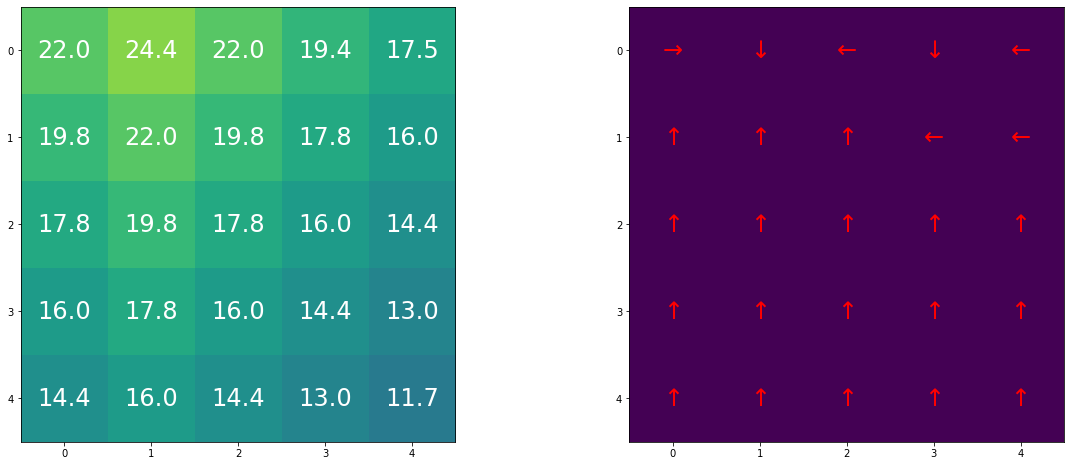

In [ ]:
def value_iteration(environment, gamma, eps=1e-6, max_iter=1000):
    """Implement of Value Iteration algorithm.

    Parameters
    ----------
    gamma: float
        discount factor.
    eps: float 
        desired precision.
    max_iter: int 
        Max number of iterations. 
    value_function: TabularValueFunction, optional. 
        Initial value function. 
        
    Returns
    -------
    value_function: TabularValueFunction
        Optimal value function.
    policy: Tabular Policy 
        Optimal policy. 
    num_iter: int
        Number of iterations to reach `eps' accuracy. 

    References
    ----------
    Sutton, R. S., & Barto, A. G. (2018). Reinforcement learning: An introduction.
    MIT press.
    Chapter 4.4

    """
    policy, value_function = init_policy_and_value_function()

    for num_iter in range(max_iter):
        error = 0

        old_value_function = copy.deepcopy(value_function)
        for state in range(environment.num_states):
            ### ---TASK 3.1--- ###
            ### YOUR CODE HERE ###
            value_action = torch.zeros(environment.num_actions)

            ### YOUR CODE END ###
            
            for action in range(environment.num_actions):
                value_estimate = 0

                # In practice, we do not have access to environment.transitions, but only to samples of it!.
                for transition in environment.transitions[(state, action)]:  
                    next_state = torch.tensor(transition["next_state"]).long()
                    reward = torch.tensor(transition["reward"]).double()
                    transition_probability = transition["probability"]

                    ### ---TASK 3.2--- ###
                    ### YOUR CODE HERE ###
                    # V[s] = max[a]{ sum[s',r] { p(s',r|s,a)[r + gamma*V[s']] } }
                    value_estimate += transition_probability * (reward + gamma * value_function(next_state).item())
                    
                value_action[action] = value_estimate
                    ### YOUR CODE END ###

                
            state = torch.tensor(state).long()
            
            ### ---TASK 3.3--- ###
            ### YOUR CODE HERE ###
            value_action, action = torch.max(value_action,0) 
            value_function.set_value(state, value_action) 
            error = max(error, np.abs(old_value_function(state).item() - value_action.item())) 
            
            ### YOUR CODE END ### 
            
            policy.set_value(state, action)

        if error < eps:
            break

    return value_function, policy, num_iter 



### ---Task 3.4--- ###
value_function, policy, num_iter = value_iteration(environment, gamma)
plot_value_and_policy(value_function.table.reshape(5, 5).detach().numpy(),
                      policy.table.argmax(0).reshape(5, 5).detach().numpy())
print(f"Iterations until convergence: {num_iter}")